# Data Preprocessing

The data is formatted as JSON separated by newline. Using pandas to read dataset

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

dataframe = pd.read_json("./Software_5.json", lines=True)

print(dataframe.info(verbose=True, show_counts=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12805 entries, 0 to 12804
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         12805 non-null  int64 
 1   verified        12805 non-null  bool  
 2   reviewTime      12805 non-null  object
 3   reviewerID      12805 non-null  object
 4   asin            12805 non-null  object
 5   style           7161 non-null   object
 6   reviewerName    12796 non-null  object
 7   reviewText      12804 non-null  object
 8   summary         12799 non-null  object
 9   unixReviewTime  12805 non-null  int64 
 10  vote            3902 non-null   object
 11  image           71 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 1.1+ MB
None


The feature `vote` tells us if the review is helpful or not. To better classifying our data, we want to remove all reviews that have no vote.

Also, note that the data type of `vote` is `object`. But since vote can only be a number, we want to convert vote to `int64` data type

Now after preprocessing the vote, we can see that the data type of vote is `int64`

In [49]:
df = dataframe[dataframe['vote'].notna()]

# Some vote has , in number, we just need to remove it
processed_vote = df['vote'].apply(lambda x: x.replace(",", ""))
df['vote'] = pd.to_numeric(processed_vote)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3902 entries, 2 to 12798
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         3902 non-null   int64 
 1   verified        3902 non-null   bool  
 2   reviewTime      3902 non-null   object
 3   reviewerID      3902 non-null   object
 4   asin            3902 non-null   object
 5   style           1975 non-null   object
 6   reviewerName    3897 non-null   object
 7   reviewText      3902 non-null   object
 8   summary         3898 non-null   object
 9   unixReviewTime  3902 non-null   int64 
 10  vote            3902 non-null   int64 
 11  image           53 non-null     object
dtypes: bool(1), int64(3), object(8)
memory usage: 369.6+ KB


C:\Users\Long Viet Ta\AppData\Local\Temp\ipykernel_12364\4132878064.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vote'] = pd.to_numeric(processed_vote)


For feature `reviewText`, we want to do some pre processing steps on the text. Notably:

- Lemmetization  
- Expand contraction   
- Lower all words

In [50]:
from nltk.corpus import stopwords
import nltk
import string
import contractions


def remove_special_symbol(text: str) -> str:
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def lower_text(text: str) -> str:
    return text.lower()


def remove_stop_words(text: str) -> str:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    return ' '.join(
        [word for word in text.split() if word not in (stop_words)])


def expand_contraction(text: str) -> str:
    return contractions.fix(text)


def stemming(text: str) -> str:
    stemmer = nltk.stem.SnowballStemmer("english")
    return stemmer.stem(text)


df["processed_review"] = df["reviewText"].apply(lower_text).apply(expand_contraction).apply(
    remove_stop_words).apply(remove_special_symbol).apply(stemming)


[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date

Each review is assigned an overall score from 1.0 to 5.0. Convert those scores to labels where -1 is negative, 0 is neutral and 1 is positive

In [51]:
def sentiment_from_overall(number):
    if number < 3.0:
        return -1
    if number == 3.0:
        return 0
    return 1

df["sentiment"] = df["overall"].apply(sentiment_from_overall)

C:\Users\Long Viet Ta\AppData\Local\Temp\ipykernel_12364\3092702451.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df["overall"].apply(sentiment_from_overall)


# Visualization

Exploratory data analysis on overall rating column

In [52]:
df["overall"].describe()


count    3902.000000
mean        3.367760
std         1.557351
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: overall, dtype: float64

Plotting pie chart and bar chart for overall score distribution. The 'overall' column has 5 labels: 1.0, 2.0, 3.0, 4.0, 5.0 where 1.0 is very bad, 3.0 is neutral and 5.0 is very good.

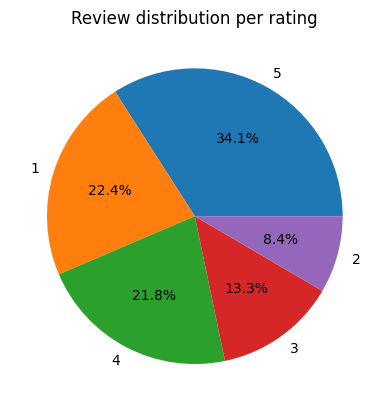

<AxesSubplot: title={'center': 'Review count per rating'}>

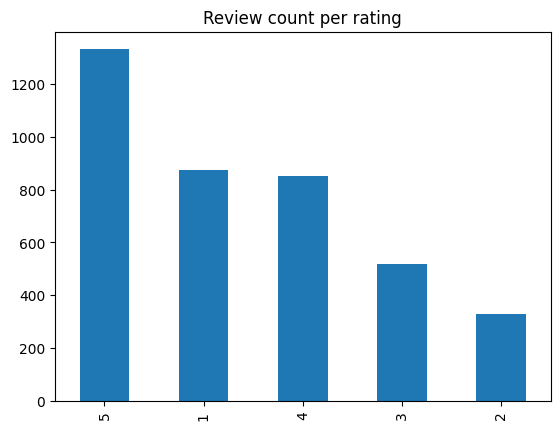

In [53]:
scores = df["overall"].value_counts()
index = scores.index.to_numpy()
scores = scores.to_numpy()
plt.pie(scores, labels=index, autopct='%1.1f%%')
plt.title("Review distribution per rating")
plt.show()
df['overall'].value_counts().plot(kind='bar',title="Review count per rating")


We get the same statistic, but this time with sentiment

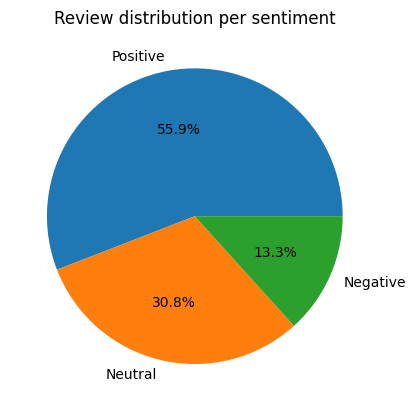

<AxesSubplot: title={'center': 'Review count per sentiment'}>

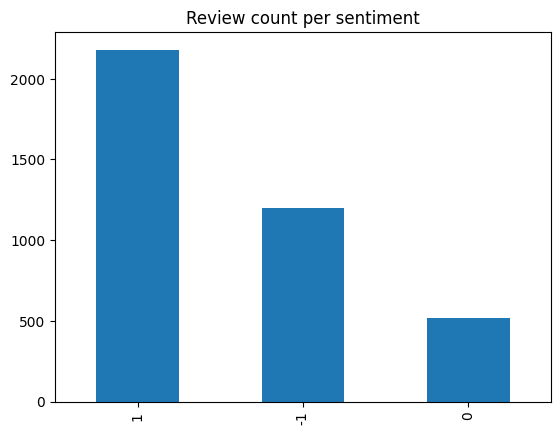

In [54]:
def sentiment_to_word(number):
    if number == 1:
        return "Positive"
    if number == 0:
        return "Negative"
    return "Neutral"

scores = df["sentiment"].value_counts()
index = [sentiment_to_word(x) for x in scores.index.to_numpy()]
scores = scores.to_numpy()
plt.pie(scores, labels=index, autopct='%1.1f%%')
plt.title("Review distribution per sentiment")
plt.show()
df['sentiment'].value_counts().plot(kind='bar',title="Review count per sentiment")


Now, we get statistics on reivewText length. To visualize this, we use a boxplot

Statistic of text length
 count     3902.000000
mean      1137.915428
std       1409.747266
min          3.000000
25%        361.000000
50%        734.000000
75%       1428.500000
max      23075.000000
Name: processed_review, dtype: float64


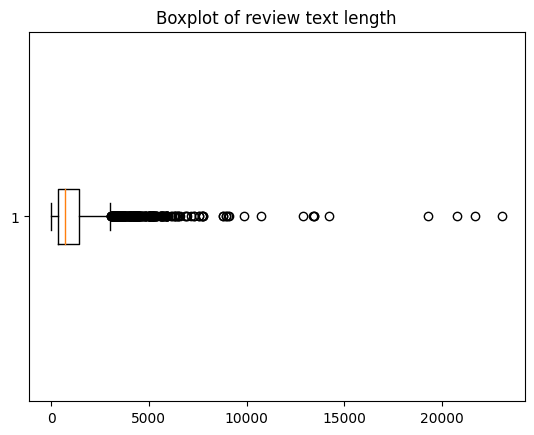

In [72]:
text_length = df["processed_review"].apply(len)
print("Statistic of text length\n", text_length.describe())
# To visualize this, we use boxplot
plt.title("Boxplot of review text length")
plt.boxplot(text_length, vert=False)
plt.show()


Wordcloud to visualize top words in our `processed_review` column

Text(0.5, 1.0, 'Most popular words in dataset')

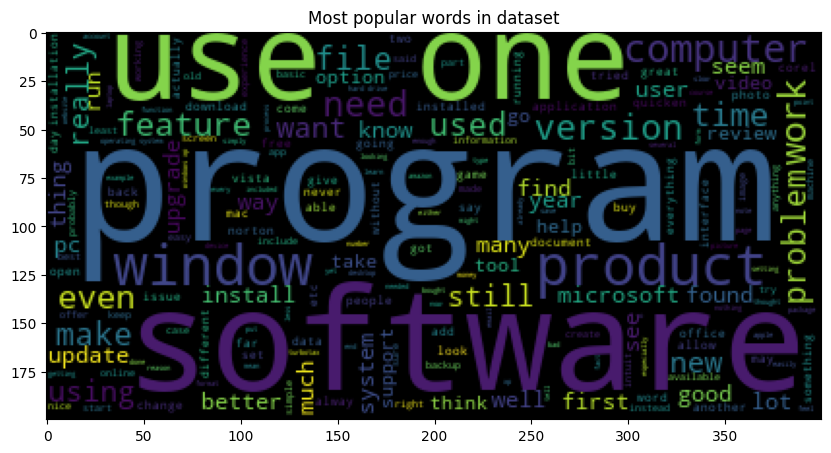

In [70]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(df['processed_review']))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(wordcloud)
ax.set_title("Most popular words in dataset")


Next up, we want to visualize the correlation between `vote` and `rating` in our dataframe. There is no correlation between `vote` and `rating`. Therefore,
we conclude that by removing samples that have no `vote`, it creates no bias for our dataset

<AxesSubplot: title={'center': 'Correlation between features'}>

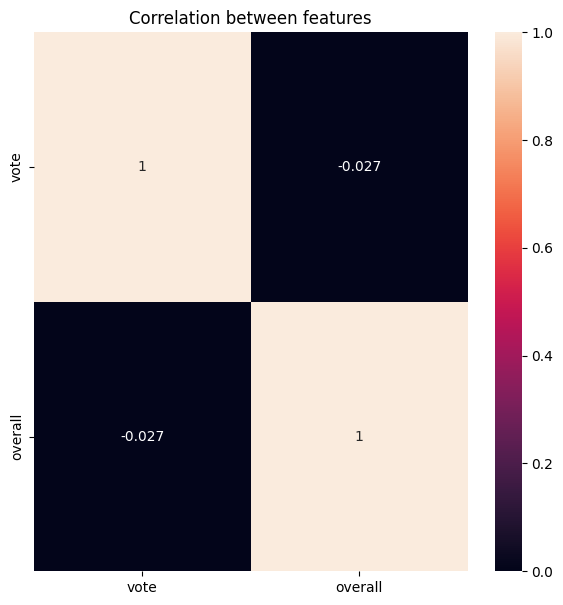

In [68]:
from seaborn import heatmap

correlation = df[["vote", "overall"]].corr()
plt.figure(figsize=(7, 7))
plt.title("Correlation between features")
heatmap(correlation, vmin=0, vmax=1, annot=True)
